<a href="https://colab.research.google.com/github/itu-itis23-cebecim22/hw3/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. SETUP & DATA LOADING ---
import os
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from skimage import color
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from google.colab import drive

# Need pytorch-fid for evaluation later
try:
    import pytorch_fid
except ImportError:
    import subprocess
    print("Installing pytorch-fid...")
    subprocess.check_call(["pip", "install", "pytorch-fid"])

# CONFIG
CONFIG = {
    "EPOCHS": 100,          # sticking to 100 epochs for now
    "BATCH_SIZE": 32,       # 32 works fine on Colab GPU
    "LR": 0.0002,
    "BETA1": 0.5,
    "LAMBDA_L1": 100.0,
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}
print(f"Current Config: {CONFIG}")

# DRIVE & PATHS
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

ZIP_PATH = '/content/drive/MyDrive/processeddata.zip'
EXTRACT_PATH = '/content/dataset'

# Paths defined in preprocessing step
TRAIN_DIR = '/content/dataset/processed/train'
VAL_DIR =   '/content/dataset/processed/val'
TEST_DIR =  '/content/dataset/processed/test'

# Unzip if not exists
if not os.path.exists(TRAIN_DIR):
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Zip extraction done.")
else:
    print("Dataset already extracted.")

#CUSTOM DATASET
class NumpyColorizationDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        # Load numpy arrays directly
        self.L_data = np.load(os.path.join(root_dir, 'L.npy'))
        self.ab_data = np.load(os.path.join(root_dir, 'ab.npy'))

    def __len__(self):
        return len(self.L_data)

    def __getitem__(self, idx):
        L = torch.from_numpy(self.L_data[idx]).float()
        ab = torch.from_numpy(self.ab_data[idx]).float()

        # handling dimensions
        if L.ndim == 2: L = L.unsqueeze(0)
        elif L.shape[-1] == 1: L = L.permute(2, 0, 1)

        if ab.shape[0] != 2: ab = ab.permute(2, 0, 1)

        return {'L': L, 'ab': ab}

#DATALOADERS
print("Loading datasets...")
if os.path.exists(TRAIN_DIR) and os.path.exists(VAL_DIR) and os.path.exists(TEST_DIR):
    train_ds = NumpyColorizationDataset(TRAIN_DIR)
    val_ds = NumpyColorizationDataset(VAL_DIR)
    test_ds = NumpyColorizationDataset(TEST_DIR)

    loaders = {}
    loaders['train'] = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
    loaders['val'] = DataLoader(val_ds, batch_size=16, shuffle=False)
    loaders['test'] = DataLoader(test_ds, batch_size=16, shuffle=True)

    print(f"Load success:\n   Train: {len(train_ds)}\n   Val:   {len(val_ds)}\n   Test:  {len(test_ds)}")
else:
    print(f"Error: Missing directories. Check:\n{TRAIN_DIR}\n{VAL_DIR}")

Installing pytorch-fid...
Current Config: {'EPOCHS': 100, 'BATCH_SIZE': 32, 'LR': 0.0002, 'BETA1': 0.5, 'LAMBDA_L1': 100.0, 'DEVICE': device(type='cuda')}
Mounted at /content/drive
Extracting dataset...
Zip extraction done.
Loading datasets...
Load success:
   Train: 2045
   Val:   256
   Test:  256


In [6]:
#2. MODEL ARCHITECTURES ---

# Weight Initilazing
def init_weights(m):
    # Standard init
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

#AUTOENCODER
class AEBlock(nn.Module):
    def __init__(self, in_c, out_c, submodule=None, outer=False, inner=False):
        super(AEBlock, self).__init__()
        down = nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)
        up = nn.ConvTranspose2d(out_c, in_c, 4, 2, 1, bias=False)

        # Original compact logic
        if outer:
            model = [down, submodule, nn.ReLU(), nn.ConvTranspose2d(out_c, 2, 4, 2, 1), nn.Tanh()]
        elif inner:
            model = [nn.LeakyReLU(0.2), down, nn.ReLU(), up, nn.BatchNorm2d(in_c)]
        else:
            model = [nn.LeakyReLU(0.2), down, nn.BatchNorm2d(out_c), submodule, nn.ReLU(), up, nn.BatchNorm2d(in_c)]

        self.model = nn.Sequential(*model)

    def forward(self, x): return self.model(x)

class AutoencoderGenerator(nn.Module):
    def __init__(self):
        super(AutoencoderGenerator, self).__init__()
        # Using nested blocks
        m = AEBlock(512, 512, inner=True)
        m = AEBlock(256, 512, submodule=m)
        m = AEBlock(128, 256, submodule=m)
        m = AEBlock(64, 128, submodule=m)
        self.model = AEBlock(1, 64, submodule=m, outer=True)

    def forward(self, x): return self.model(x)

# U-NET
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        # Compact helper functions
        def down(i, o, norm=True):
            l = [nn.Conv2d(i, o, 4, 2, 1)]
            if norm: l.append(nn.BatchNorm2d(o))
            l.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*l)

        def up(i, o, drop=0.0):
            l = [nn.ConvTranspose2d(i, o, 4, 2, 1), nn.BatchNorm2d(o), nn.ReLU()]
            if drop: l.append(nn.Dropout(drop))
            return nn.Sequential(*l)

        self.d1 = down(1, 64, False)
        self.d2 = down(64, 128)
        self.d3 = down(128, 256)
        self.d4 = down(256, 512)

        self.u1 = up(512, 256)
        self.u2 = up(512, 128)
        self.u3 = up(256, 64)

        self.final = nn.Sequential(nn.ConvTranspose2d(128, 2, 4, 2, 1), nn.Tanh())

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        u1 = self.u1(d4)
        u2 = self.u2(torch.cat([u1, d3], 1))
        u3 = self.u3(torch.cat([u2, d2], 1))
        return self.final(torch.cat([u3, d1], 1))

# DISCRIMINATOR
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()

        def block(i, o, norm=True):
            l = [nn.Conv2d(i, o, 4, 2, 1), nn.LeakyReLU(0.2, True)]
            if norm: l.insert(1, nn.BatchNorm2d(o))
            return nn.Sequential(*l)

        self.model = nn.Sequential(
            block(3, 64, norm=False),
            block(64, 128),
            block(128, 256),
            nn.Conv2d(256, 1, 4, 1, 1)
        )

    def forward(self, x): return self.model(x)

print("Models initialized ")

Models initialized 


Initializing models...
Starting training for 100 epochs...
Epoch [5/100]
   Train -> AE: 0.1025 | U-Net: 0.1027 | GAN(G): 11.8213
   Val   -> AE: 0.1087 | U-Net: 0.1088 | GAN(G): 13.8289
Epoch [10/100]
   Train -> AE: 0.0983 | U-Net: 0.1001 | GAN(G): 11.7493
   Val   -> AE: 0.0987 | U-Net: 0.1002 | GAN(G): 15.1095
Epoch [15/100]
   Train -> AE: 0.0857 | U-Net: 0.0984 | GAN(G): 11.4508
   Val   -> AE: 0.0986 | U-Net: 0.1063 | GAN(G): 17.5216
Epoch [20/100]
   Train -> AE: 0.0677 | U-Net: 0.0973 | GAN(G): 11.0358
   Val   -> AE: 0.0961 | U-Net: 0.1014 | GAN(G): 18.8151
Epoch [25/100]
   Train -> AE: 0.0591 | U-Net: 0.0955 | GAN(G): 10.2359
   Val   -> AE: 0.0960 | U-Net: 0.1068 | GAN(G): 12.5269
Epoch [30/100]
   Train -> AE: 0.0541 | U-Net: 0.0916 | GAN(G): 9.4551
   Val   -> AE: 0.0975 | U-Net: 0.1027 | GAN(G): 13.2259
Epoch [35/100]
   Train -> AE: 0.0511 | U-Net: 0.0862 | GAN(G): 8.7069
   Val   -> AE: 0.0929 | U-Net: 0.1003 | GAN(G): 12.5670
Epoch [40/100]
   Train -> AE: 0.0502 | U

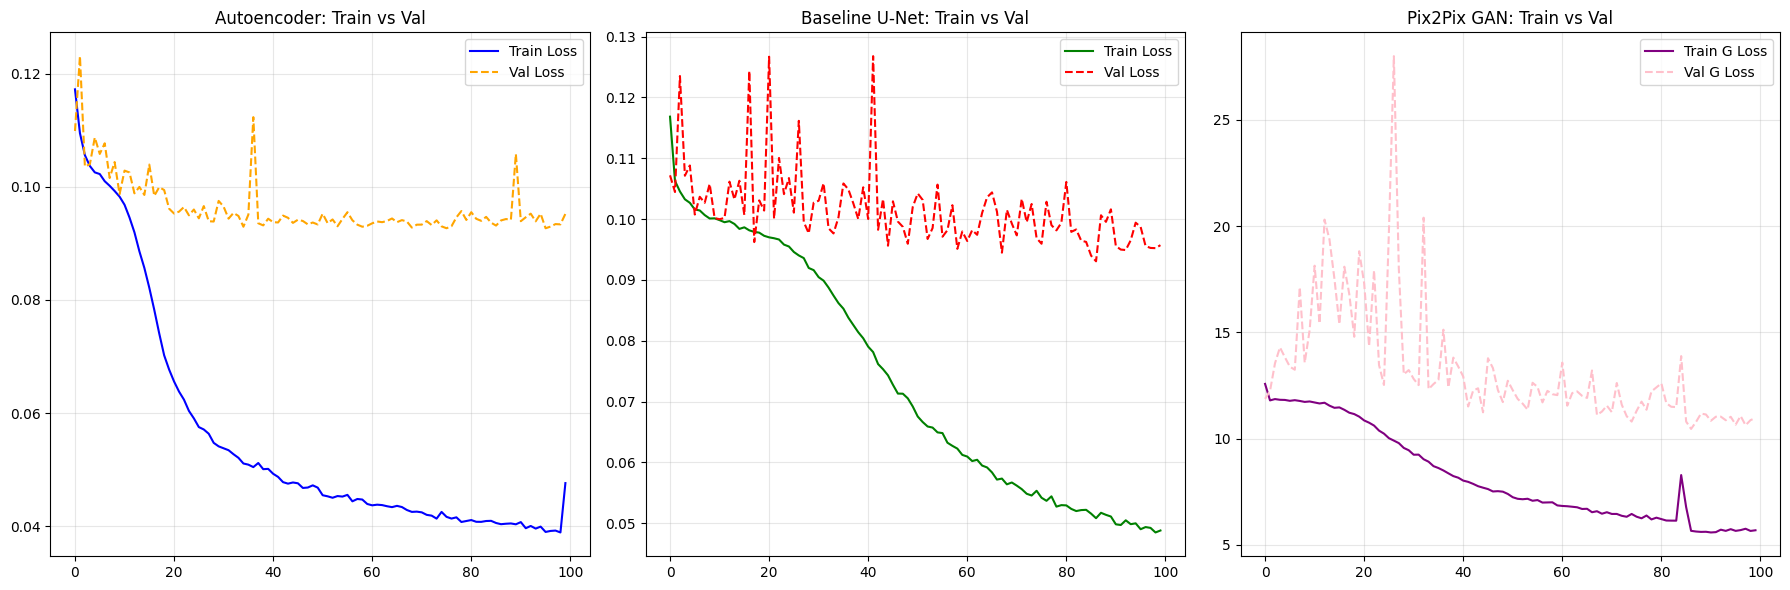

In [3]:
#3. MAIN TRAINING LOOP
import matplotlib.pyplot as plt
import os
import time

start_time = time.time()

# Setup models
print("Initializing models...")
model_ae = AutoencoderGenerator().to(CONFIG['DEVICE'])
model_unet = UNetGenerator().to(CONFIG['DEVICE'])
model_gan = UNetGenerator().to(CONFIG['DEVICE'])
disc = PatchGANDiscriminator().to(CONFIG['DEVICE'])

# Apply weight initialization
for m in [model_ae, model_unet, model_gan, disc]:
    m.apply(init_weights)

# Optimizers (Adam with beta1=0.5 for GAN stability)
opt_ae = optim.Adam(model_ae.parameters(), lr=CONFIG['LR'], betas=(CONFIG['BETA1'], 0.999))
opt_unet = optim.Adam(model_unet.parameters(), lr=CONFIG['LR'], betas=(CONFIG['BETA1'], 0.999))
opt_g = optim.Adam(model_gan.parameters(), lr=CONFIG['LR'], betas=(CONFIG['BETA1'], 0.999))
opt_d = optim.Adam(disc.parameters(), lr=CONFIG['LR'], betas=(CONFIG['BETA1'], 0.999))

# Loss functions
criterion_L1 = nn.L1Loss()
criterion_GAN = nn.MSELoss() # LSGAN loss

# History tracking
history = {
    'train_ae': [], 'val_ae': [],
    'train_unet': [], 'val_unet': [],
    'train_gan_g': [], 'val_gan_g': [],
    'train_gan_d': []
}

print(f"Starting training for {CONFIG['EPOCHS']} epochs...")

for epoch in range(CONFIG['EPOCHS']):
    # 1. TRAINING PHASE
    model_ae.train(); model_unet.train(); model_gan.train(); disc.train()
    epoch_loss = {'ae': 0.0, 'unet': 0.0, 'gan_g': 0.0, 'gan_d': 0.0}

    for data in loaders['train']:
        L = data['L'].to(CONFIG['DEVICE'])
        ab = data['ab'].to(CONFIG['DEVICE'])

        #Train Autoencoder
        opt_ae.zero_grad()
        loss_ae = criterion_L1(model_ae(L), ab)
        loss_ae.backward()
        opt_ae.step()
        epoch_loss['ae'] += loss_ae.item()

        #Train Baseline U-Net
        opt_unet.zero_grad()
        loss_unet = criterion_L1(model_unet(L), ab)
        loss_unet.backward()
        opt_unet.step()
        epoch_loss['unet'] += loss_unet.item()

        #Train GAN
        #Update Discriminator
        fake_ab = model_gan(L)
        real_img = torch.cat([L, ab], 1)
        fake_img = torch.cat([L, fake_ab.detach()], 1)

        loss_D = (criterion_GAN(disc(real_img), torch.ones_like(disc(real_img))) +
                  criterion_GAN(disc(fake_img), torch.zeros_like(disc(fake_img)))) * 0.5

        opt_d.zero_grad()
        loss_D.backward()
        opt_d.step()
        epoch_loss['gan_d'] += loss_D.item()

        #Update Generator
        fake_img_G = torch.cat([L, fake_ab], 1)
        #G Loss = Adversarial Loss + Lambda * L1 Loss
        loss_G = criterion_GAN(disc(fake_img_G), torch.ones_like(disc(fake_img_G))) + \
                 (criterion_L1(fake_ab, ab) * CONFIG['LAMBDA_L1'])

        opt_g.zero_grad()
        loss_G.backward()
        opt_g.step()
        epoch_loss['gan_g'] += loss_G.item()

    # Record Train averages
    len_train = len(loaders['train'])
    history['train_ae'].append(epoch_loss['ae'] / len_train)
    history['train_unet'].append(epoch_loss['unet'] / len_train)
    history['train_gan_g'].append(epoch_loss['gan_g'] / len_train)
    history['train_gan_d'].append(epoch_loss['gan_d'] / len_train)

    # 2. VALIDATION PHASE
    model_ae.eval(); model_unet.eval(); model_gan.eval()
    val_loss = {'ae': 0.0, 'unet': 0.0, 'gan_g': 0.0}

    with torch.no_grad():
        for data in loaders['val']:
            L = data['L'].to(CONFIG['DEVICE'])
            ab = data['ab'].to(CONFIG['DEVICE'])

            # AE Val
            val_loss['ae'] += criterion_L1(model_ae(L), ab).item()
            # U-Net Val
            val_loss['unet'] += criterion_L1(model_unet(L), ab).item()

            # GAN Val (checking total G loss for comparison)
            fake_ab = model_gan(L)
            fake_img_G = torch.cat([L, fake_ab], 1)
            loss_G_val = criterion_GAN(disc(fake_img_G), torch.ones_like(disc(fake_img_G))) + \
                         (criterion_L1(fake_ab, ab) * CONFIG['LAMBDA_L1'])
            val_loss['gan_g'] += loss_G_val.item()

    len_val = len(loaders['val'])
    history['val_ae'].append(val_loss['ae'] / len_val)
    history['val_unet'].append(val_loss['unet'] / len_val)
    history['val_gan_g'].append(val_loss['gan_g'] / len_val)

    # Logging every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{CONFIG['EPOCHS']}]")
        print(f"   Train -> AE: {history['train_ae'][-1]:.4f} | U-Net: {history['train_unet'][-1]:.4f} | GAN(G): {history['train_gan_g'][-1]:.4f}")
        print(f"   Val   -> AE: {history['val_ae'][-1]:.4f} | U-Net: {history['val_unet'][-1]:.4f} | GAN(G): {history['val_gan_g'][-1]:.4f}")

# SAVE & PLOT
SAVE_DIR = '/content/drive/MyDrive/Project_Models_Val'
os.makedirs(SAVE_DIR, exist_ok=True)
torch.save(model_ae.state_dict(), f"{SAVE_DIR}/model_ae.pth")
torch.save(model_gan.state_dict(), f"{SAVE_DIR}/model_gan.pth")
print(f"Models saved to: {SAVE_DIR}")

total_time = time.time() - start_time
print(f"Total training time: {total_time/60:.2f} min ({total_time/3600:.2f} hrs)")

# Plotting Loss Curves
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history['train_ae'], label='Train Loss', color='blue')
plt.plot(history['val_ae'], label='Val Loss', color='orange', linestyle='--')
plt.title('Autoencoder: Train vs Val')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history['train_unet'], label='Train Loss', color='green')
plt.plot(history['val_unet'], label='Val Loss', color='red', linestyle='--')
plt.title('Baseline U-Net: Train vs Val')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history['train_gan_g'], label='Train G Loss', color='purple')
plt.plot(history['val_gan_g'], label='Val G Loss', color='pink', linestyle='--')
plt.title('Pix2Pix GAN: Train vs Val')
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

pytorch-fid is installed.

>>> Evaluating Autoencoder...


/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 8 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 26 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted

   Generating images for FID (Autoencoder)...


/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 55 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 65 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 107 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resul

   Running FID calculation...

>>> Evaluating Baseline U-Net...


/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))


   Generating images for FID (Baseline_U-Net)...
   Running FID calculation...

>>> Evaluating Pix2Pix (GAN)...


/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 38 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 17 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space result

   Generating images for FID (Pix2Pix_(GAN))...


/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 25 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 31 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 100 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))
/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resul

   Running FID calculation...

                 FINAL QUANTITATIVE RESULTS                 
Model Name           | PSNR (↑)   | SSIM (↑)   | FID (↓)   
------------------------------------------------------------
Autoencoder          | 21.89       | 0.9110     | 121.39
Baseline U-Net       | 21.79       | 0.9029     | 123.16
Pix2Pix (GAN)        | 20.85       | 0.8654     | 110.03

Generating visual comparison plots...


/tmp/ipython-input-3342441817.py:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 30 negative Z values that have been clipped to zero
  return color.lab2rgb(np.concatenate((L, ab), axis=2))


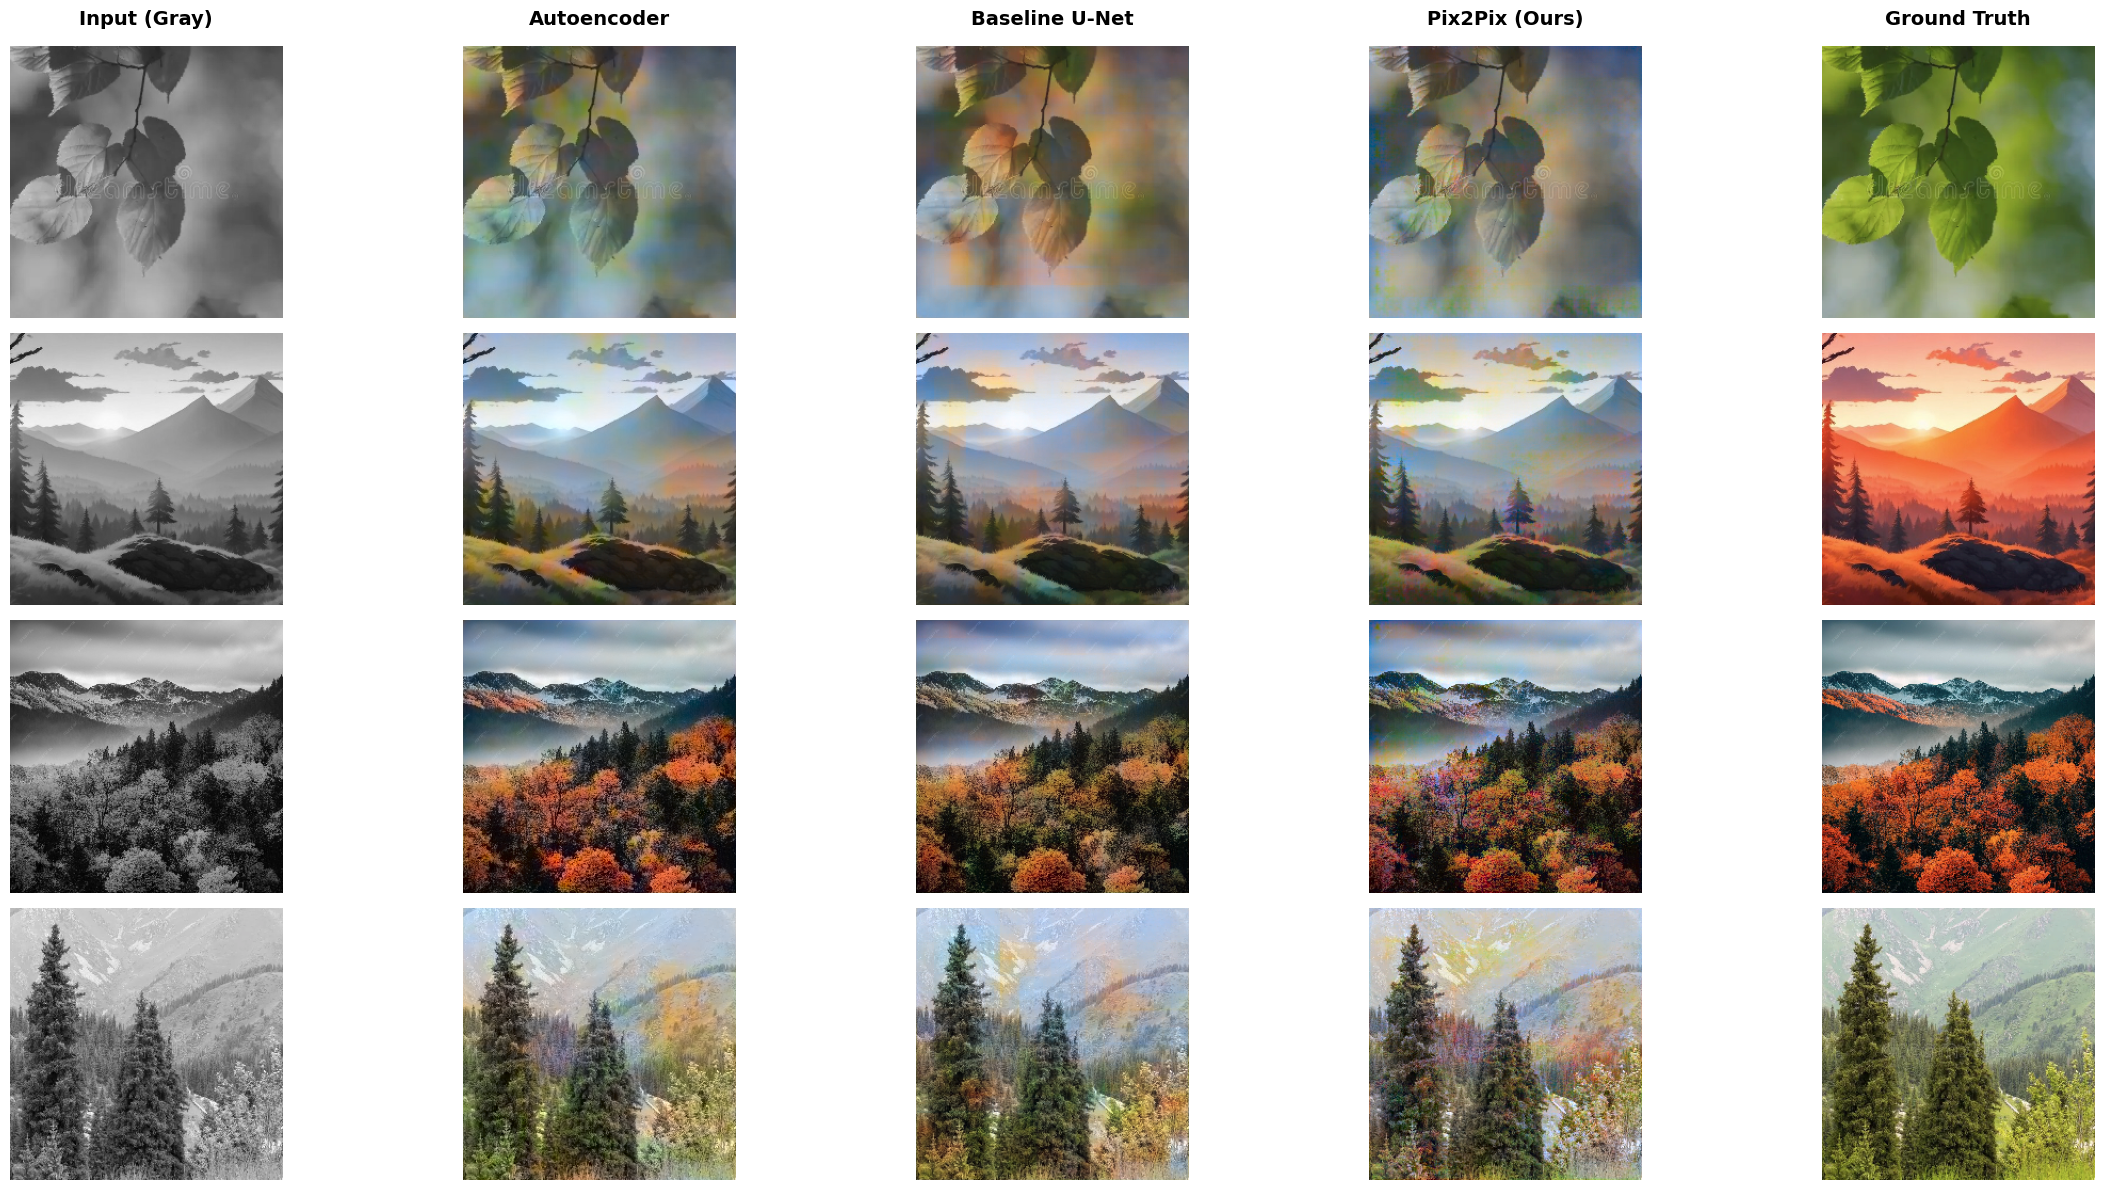

In [5]:
#4. EVALUATION & VISUALIZATION
import subprocess
import shutil
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Check for FID library
try:
    import pytorch_fid
    print("pytorch-fid is installed.")
except ImportError:
    print("Installing pytorch-fid...")
    subprocess.check_call(["pip", "install", "pytorch-fid"])
    print("Installation complete.")

def lab_to_rgb_numpy(L, ab):
    if isinstance(L, torch.Tensor): L = L.cpu().detach().numpy()
    if isinstance(ab, torch.Tensor): ab = ab.cpu().detach().numpy()
    if len(L.shape) == 4: L, ab = L[0], ab[0]
    if L.shape[0] == 1: L = L.transpose((1, 2, 0))
    if ab.shape[0] == 2: ab = ab.transpose((1, 2, 0))
    L = L * 100.0; ab = ab * 110.0
    return color.lab2rgb(np.concatenate((L, ab), axis=2))

# FID calculation
def calculate_fid_score(model, loader, temp_name="temp"):
    model.eval()
    path_real = f"/content/fid_{temp_name}_real"
    path_fake = f"/content/fid_{temp_name}_fake"
    if os.path.exists(path_real): shutil.rmtree(path_real)
    if os.path.exists(path_fake): shutil.rmtree(path_fake)
    os.makedirs(path_real); os.makedirs(path_fake)

    print(f"   Generating images for FID ({temp_name})...")
    count = 0
    with torch.no_grad():
        for data in loader:
            L = data['L'].to(CONFIG['DEVICE']); ab = data['ab'].to(CONFIG['DEVICE'])
            fake_ab = model(L)
            for i in range(L.size(0)):
                real = lab_to_rgb_numpy(L[i], ab[i])
                fake = lab_to_rgb_numpy(L[i], fake_ab[i])
                plt.imsave(f"{path_real}/{count}.png", real)
                plt.imsave(f"{path_fake}/{count}.png", fake)
                count += 1
            if count >= 100: break

    print(f"   Running FID calculation...")
    result = subprocess.run(["python", "-m", "pytorch_fid", path_real, path_fake, "--device", "cuda"], capture_output=True, text=True)
    try:
        fid_value = float(result.stdout.strip().split('\n')[-1].split(':')[-1].strip())
    except:
        fid_value = 999.99
    shutil.rmtree(path_real); shutil.rmtree(path_fake)
    return fid_value

def calculate_metrics_all(model, loader, name):
    print(f"\n>>> Evaluating {name}...")
    model.eval()
    total_psnr, total_ssim, count = 0, 0, 0
    with torch.no_grad():
        for data in loader:
            L = data['L'].to(CONFIG['DEVICE']); ab = data['ab'].to(CONFIG['DEVICE'])
            fake_ab = model(L)
            for i in range(L.size(0)):
                real = lab_to_rgb_numpy(L[i], ab[i])
                fake = lab_to_rgb_numpy(L[i], fake_ab[i])
                total_psnr += psnr(real, fake, data_range=1.0)
                total_ssim += ssim(real, fake, data_range=1.0, channel_axis=2)
                count += 1
                if count >= 50: break
            if count >= 50: break

    fid_score = calculate_fid_score(model, loader, name.replace(" ", "_"))
    return total_psnr/count, total_ssim/count, fid_score

#Evaluation execution
results_list = []
models_list = [
    ("Autoencoder", model_ae),
    ("Baseline U-Net", model_unet),
    ("Pix2Pix (GAN)", model_gan)
]

# Firstly we make calculations
for name, model in models_list:
    p, s, f = calculate_metrics_all(model, loaders['test'], name)
    results_list.append((name, p, s, f))

#Final table printing
print("\n" + "="*60)
print(f"{'FINAL QUANTITATIVE RESULTS':^60}")
print("="*60)
print(f"{'Model Name':<20} | {'PSNR (↑)':<10} | {'SSIM (↑)':<10} | {'FID (↓)':<10}")
print("-" * 60)

for name, p, s, f in results_list:
    print(f"{name:<20} | {p:.2f}       | {s:.4f}     | {f:.2f}")
print("="*60)

# visualization
print("\nGenerating visual comparison plots...")
model_ae.eval(); model_unet.eval(); model_gan.eval()
data = next(iter(loaders['test']))
L = data['L'].to(CONFIG['DEVICE'])[:4]; ab = data['ab'].to(CONFIG['DEVICE'])[:4]

with torch.no_grad():
    out_ae, out_unet, out_gan = model_ae(L), model_unet(L), model_gan(L)

plt.figure(figsize=(24, 12))
titles = ["Input (Gray)", "Autoencoder", "Baseline U-Net", "Pix2Pix (Ours)", "Ground Truth"]
for i in range(4):
    imgs = [lab_to_rgb_numpy(L[i], torch.zeros_like(ab[i])),
            lab_to_rgb_numpy(L[i], out_ae[i]),
            lab_to_rgb_numpy(L[i], out_unet[i]),
            lab_to_rgb_numpy(L[i], out_gan[i]),
            lab_to_rgb_numpy(L[i], ab[i])]
    for col, (img, title) in enumerate(zip(imgs, titles)):
        plt.subplot(4, 5, i*5 + col + 1)
        plt.imshow(img); plt.axis('off')
        if i==0: plt.title(title, fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()